<a href="https://colab.research.google.com/github/stefvas/neural-networks/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##TENSORFLOW/KERAS

In [ ]:
!sudo pip install --upgrade pip
!sudo pip install --upgrade tensorflow

     |████████████████████████████████| 2.1 MB 15.8 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 KB 14.4 MB/s eta 0:00:00


#Imports

In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import tensorflow as tf
import tensorflow.keras.applications as app
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, SpatialDropout2D, ZeroPadding2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import layers,callbacks,regularizers
from tensorflow import keras
import seaborn as sns

import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import time
import timeit
!pip install tf-explain
!pip install pyyaml h5py  # Required to save models in HDF5 format

#DATA

Δεν καταφεραμε να εισαγουμε τα ζητουμενα dataset για την εκπαιδευση του deep learning μηχανισμου μας και προχωρησαμε με ενα απ τα ετοιμα dataset του KERAS

In [24]:
fashion_mnist = keras.datasets.fashion_mnist  

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [25]:
train_images.shape

(60000, 28, 28)

Αρα εχουμε εξηντα χιλιαδες φωτογραφιες οι οποιες αποτελουνται απο 28x28 pixels

In [26]:
train_labels[:10] 

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

Τα labels μασ ειναι integers απ' το 0-9, Plotαρω με το matplotlib μια εικονα για να δω πω μοιαζει

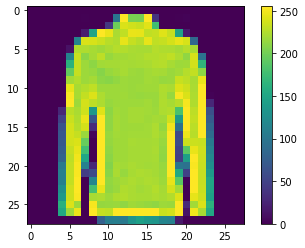

In [27]:
plt.figure()
plt.imshow(train_images[5961])
plt.colorbar()
plt.grid(False)
plt.show()

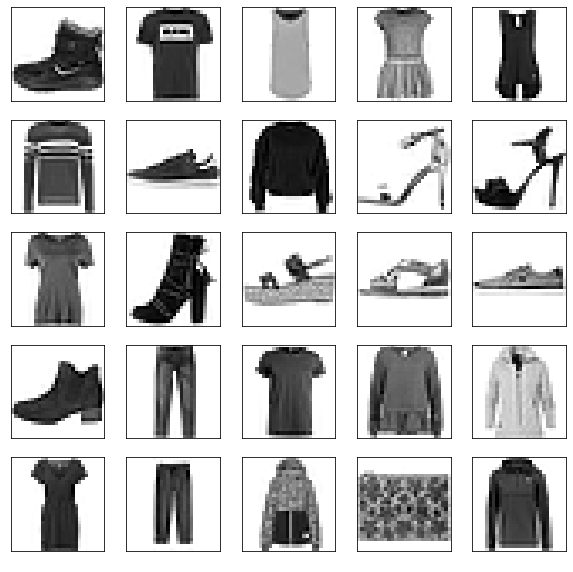

In [55]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

Υποθεση : Η εικονα απεικονιζει μαι μπλουζα
Οριζω λοιπον τις classes 

In [28]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
               

#Προεπεξεργασια των data 

Επειδη τα pixel values ειναι αναμεσα στο 0 - 255, μπορουμε να αναγουμε τα data  σε τιμες μεταξυ του μηδενος και του ενα .Αυτο το κανουμε καθως θα ειναι πιο ευκολο για το μοντελο να επεξεργαστει μικροτερες τιμες

In [23]:
train_images = train_images / 255.0

test_images = test_images / 255.0

##Building the Model
First with Sequential model to compare the results

In [46]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),  # input layer (1)
    keras.layers.Dense(128, activation='relu'),  # hidden layer (2)
    keras.layers.Dense(10, activation='softmax') # output layer (3)
])

In [47]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [56]:
model.fit(train_images, train_labels, epochs=18)


Epoch 1/18
1875/1875 [==============================] - 5s 3ms/step - loss: 4.0516 - accuracy: 0.6903
Epoch 2/18
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7336 - accuracy: 0.7286
Epoch 3/18
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6634 - accuracy: 0.7585
Epoch 4/18
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5783 - accuracy: 0.7922
Epoch 5/18
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5379 - accuracy: 0.8107
Epoch 6/18
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5276 - accuracy: 0.8159
Epoch 7/18
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5131 - accuracy: 0.8223
Epoch 8/18
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4986 - accuracy: 0.8278
Epoch 9/18
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5006 - accuracy: 0.8265
Epoch 10/18
1875/1875 [==============================] - 5s 2ms/step - loss: 0.482

In [57]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=1) 

print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.5209 - accuracy: 0.8326
Test accuracy: 0.8325999975204468


In [58]:
predictions = model.predict(test_images)

In [59]:
predictions[30]

array([4.5127590e-22, 3.0939008e-30, 1.4981157e-17, 7.0428134e-29,
       3.2657769e-24, 1.7686447e-37, 2.5869337e-31, 3.9535673e-23,
       1.0000000e+00, 2.1375315e-14], dtype=float32)

In [60]:
np.argmax(predictions[30])

8

In [61]:
test_labels[30]

8

Pick a number: 45


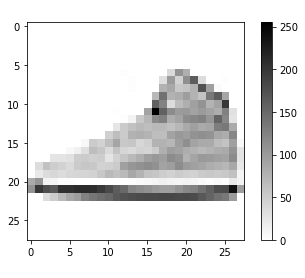

In [62]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR

def predict(model, image, correct_label):
  class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  prediction = model.predict(np.array([image]))
  predicted_class = class_names[np.argmax(prediction)]

  show_image(image, class_names[correct_label], predicted_class)


def show_image(img, label, guess):
  plt.figure()
  plt.imshow(img, cmap=plt.cm.binary)
  plt.title("Excpected: " + label)
  plt.xlabel("Guess: " + guess)
  plt.colorbar()
  plt.grid(False)
  plt.show()


def get_number():
  while True:
    num = input("Pick a number: ")
    if num.isdigit():
      num = int(num)
      if 0 <= num <= 1000:
        return int(num)
    else:
      print("Try again...")

num = get_number()
image = test_images[num]
label = test_labels[num]
predict(model, image, label)


In [64]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)


In [65]:
predictions[30]


array([0.08533674, 0.08533674, 0.08533674, 0.08533674, 0.08533674,
       0.08533674, 0.08533674, 0.08533674, 0.23196931, 0.08533674],
      dtype=float32)

In [66]:
np.argmax(predictions[30])


8

In [67]:
test_labels[30]


8

In [69]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

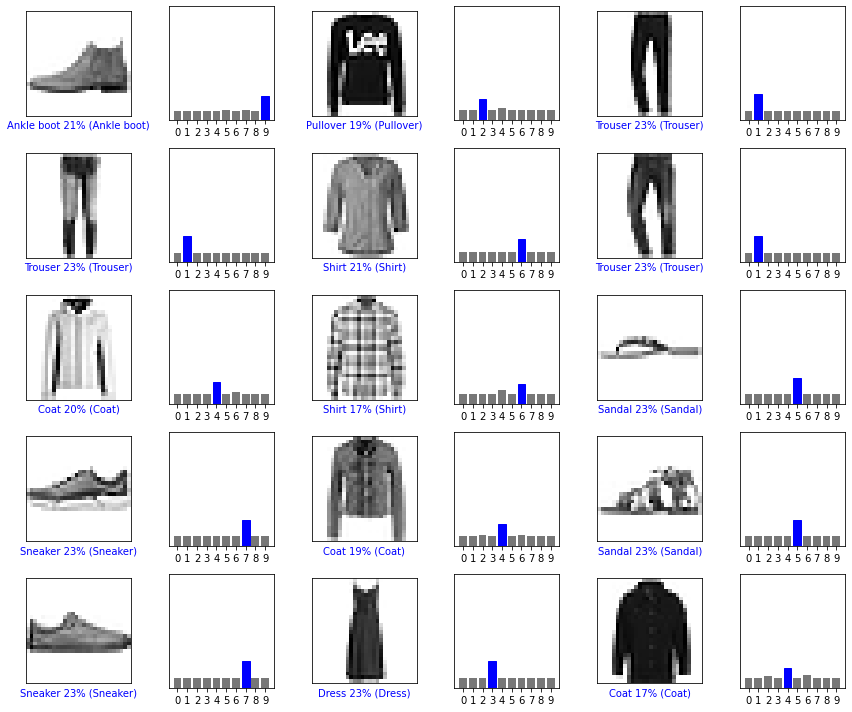

In [70]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()